<a href="https://colab.research.google.com/github/napoles-uach/Ai4sci/blob/main/Stiffness_Hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
!pip install --pre deepchem

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 608 kB 6.6 MB/s 
     |████████████████████████████████| 22.7 MB 83.6 MB/s 


In [23]:
!pip install dgl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 8.4 MB/s 


In [1]:
pip install pymatgen

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 40.6 MB 2.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 65 kB 4.7 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
     |████████████████████████████████| 98 kB 9.0 MB/s 
     |████████████████████████████████| 325 kB 32.0 MB/s 
     |████████████████████████████████| 109 kB 44.3 MB/s 
     |████████████████████████████████| 546 kB 46.3 MB/s 
  Created wheel for pymatgen: filename=pymatgen-2022.0.17-cp37-cp37m-linux_x86_64.whl size=41841022 sha256=1337e873bc3dc6a196aed5b8cee425aec4904321f2707cbb4a9e4eac68b5cef1
  Stored in directory: /root/.cache/pip/wheels/cf/f6/22/58a9be23c5f1b452770e02ff42047175eaf0f9c2f15219fc76
Successfully built pymatgen
  Attempting uninstall:

In [24]:
import deepchem as dc

In [25]:
import os
os.environ['DEEPCHEM_DATA_DIR'] = os.getcwd()

In [2]:
from pymatgen.ext.matproj import MPRester

In [3]:
mpr = MPRester("GVKAlZWLJyoftCu7f")
data2 = mpr.query({'elasticity': {'$exists': True}}, ['material_id', 'elasticity'])

100%|██████████| 13172/13172 [00:14<00:00, 888.69it/s]


In [4]:
mat_id=[] # columna con id
for i in range(len(data2)):#['material_id']
  mat_id.append(data2[i]['material_id'])

In [ ]:
for id in mat_id[:2000]:
  #print(id)
  structure = mpr.get_structure_by_material_id(id) 

In [5]:
def mat2vec(vec):
  i = -1
  stiff_vec = []
  for row in vec:
    i=i+1
    stiff_vec+=row[i:]
  return stiff_vec

In [19]:
import numpy as np

In [111]:
stiff_list = []
struc_list = []
for mat in data2:
  stiffness = mat['elasticity']['elastic_tensor']
  #id = [mat['material_id']]
  stiff_list.append(mat2vec(stiffness))
  id=mat['material_id']
  structure = mpr.get_structure_by_material_id(id)
  struc_list.append(structure)

In [112]:
X = struc_list
y = stiff_list
#dataset = dc.data.NumpyDataset(X, y)

In [113]:
featurizer = dc.feat.CGCNNFeaturizer()
ecfp = featurizer.featurize(struc_list)
ecfp.shape
#(5, 1024)
dataset = dc.data.NumpyDataset(X=ecfp, y=np.array(stiff_list))
len(dataset)

13172

In [78]:
dataset

<NumpyDataset X.shape: (1000,), y.shape: (1000, 21), w.shape: (1000, 1), task_names: [ 0  1  2 ... 18 19 20]>

In [114]:
splitter = dc.splits.RandomSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset=dataset, frac_train=0.6, frac_valid=0.2, frac_test=0.2)

In [115]:
model = dc.models.CGCNNModel(mode='regression', batch_size=32, learning_rate=0.001,n_tasks=21)
#model.fit(train_dataset)
model.fit(train_dataset, nb_epoch=5)
#model.fit()

/usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1244.7420758928572

In [ ]:
dc.metrics.mean_absolute_error

In [131]:
metric = dc.metrics.Metric(dc.metrics.mean_absolute_error)#(dc.metrics.mean_squared_error)
print("Training set score:", model.evaluate(train_dataset, [metric]))

Training set score: {'mean_absolute_error': 13.533005613376163}


In [117]:
out=model.predict(valid_dataset)

In [133]:
#out[i]

In [119]:
tru=valid_dataset

In [132]:
#tru.y[i]

In [121]:
import matplotlib.pyplot as plt


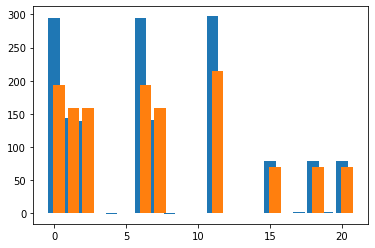

In [135]:
ind = np.arange(21)
width=0.35
i=637
fig, ax = plt.subplots()
b1 = ax.bar(ind, out[i])
b2 = ax.bar(ind+width, tru.y[i])

#ax.set_xticks(ind+width/2)
plt.show()


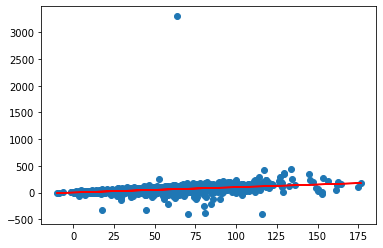

In [181]:
k=20
out_p=[]
for i in out:
  out_p.append(i[k])

out_v=[]
for i in tru.y:
  out_v.append(i[k])

plt.scatter(out_p,out_v)
plt.plot(out_p,out_p,ls='-',c='r')